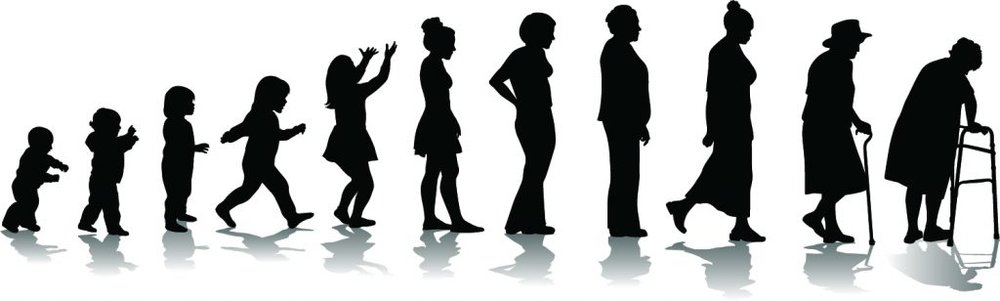

# <center>Age and Gender Prediction</center>


The <a href="https://susanqq.github.io/UTKFace/" style="color:#D18358"> UTKFace dataset </a> is a large-scale face dataset consisting of over 20,000 images. The images cover a wide range of ages and races and include both males and females. 

Using this dataset, I will be attempting to create a model capable of predicting the age and gender of an individual. I will be using part one of the cropped variations of the images, of which there are almost 10,000. However, I will only be using the first 8000 of these images due to memory limitations.

<div class="list-group" id="list-tab" role="tablist">
  <h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home" style="background-color:#D18358; border-color:#D18358">Table of Contents</h3>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#imports" role="tab" aria-controls="profile" style="color:#8F908E">Imports<span class="badge badge-primary badge-pill" style="background-color:#D18358; border-color:#D18358">1</span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#load" role="tab" aria-controls="messages" style="color:#8F908E">Loading Data<span class="badge badge-primary badge-pill" style="background-color:#D18358; border-color:#D18358">2</span></a>
  <a class="list-group-item list-group-item-action"  data-toggle="list" href="#visual" role="tab" aria-controls="settings" style="color:#8F908E">Visualising Data<span class="badge badge-primary badge-pill" style="background-color:#D18358; border-color:#D18358">3</span></a>
    <a class="list-group-item list-group-item-action" data-toggle="list" href="#split" role="tab" aria-controls="settings" style="color:#8F908E">Train Test Split<span class="badge badge-primary badge-pill" style="background-color:#D18358; border-color:#D18358">4</span></a>
    <a class="list-group-item list-group-item-action" data-toggle="list" href="#model" role="tab" aria-controls="settings" style="color:#8F908E"> Creating the Model<span class="badge badge-primary badge-pill" style="background-color:#D18358; border-color:#D18358">5</span></a>
    <a class="list-group-item list-group-item-action" data-toggle="list" href="#train" role="tab" aria-controls="settings" style="color:#8F908E">Training the Models<span class="badge badge-primary badge-pill"  style="background-color:#D18358; border-color:#D18358">6</span></a>
    <a class="list-group-item list-group-item-action" data-toggle="list" href="#eval" role="tab" aria-controls="settings" style="color:#8F908E">Evaluating the Models<span class="badge badge-primary badge-pill"  style="background-color:#D18358; border-color:#D18358">7</span></a>  

# <h1 id= 'imports'><span class="label label-default" style="background-color:#D18358; font-size:20px">1. Imports</span></h1>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# <h1 id= 'load'><span class="label label-default" style="background-color:#D18358; font-size:20px">2. Loading Data</span></h1>

In [ ]:
images = []
ages = []
genders = []

for i in os.listdir('../input/utkface-new/crop_part1/')[0:8000]:
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    images.append(Image.open('../input/utkface-new/crop_part1/' + i))

In [ ]:
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')
genders = pd.Series(list(genders), name = 'Genders')

df = pd.concat([images, ages, genders], axis=1)
df

In [ ]:
display(df['Images'][0])
print(df['Ages'][0], df['Genders'][0])

In [ ]:
display(df['Images'][1])
print(df['Ages'][1], df['Genders'][1])

So 0 corresponds to male, 1 corresponds to female.

# <h1 id= 'visual'><span class="label label-default" style="background-color:#D18358; font-size:20px">3. Visualising and Preparing Data</span></h1>

In [ ]:
sns.set_theme()
sns.distplot(df['Ages'],kde=True, bins=30)

Too many faces of people between 0 and 4 years old. The model would fit too well to these ages and not enough to the other ages. To resolve this I'm only going to include a third of the images between these ages.

In [ ]:
under4s = []

for i in range(len(df)):
    if df['Ages'].iloc[i] <= 4:
        under4s.append(df.iloc[i])
under4s = pd.DataFrame(under4s)
under4s = under4s.sample(frac=0.3)

df = df[df['Ages'] > 4]

df = pd.concat([df, under4s], ignore_index = True)

In [ ]:
sns.distplot(df['Ages'],kde=True, bins=30)

This looks much better! The dataframe is more representative of the population now. However, there aren't many images of people over 80, which would cause the model to not train well enough on those ages. It's best to just remove over 80s and only have a model that can predict the ages of people under 80.

In [ ]:
df = df[df['Ages'] < 80]

In [ ]:
sns.distplot(df['Ages'],kde=True, bins=20)

In [ ]:
sns.countplot(df['Genders'])

Not sure what 3 corresponds to - both genders, no gender, unknown, or just an error in the data entry? To be safe, I am going to remove any rows where gender equals 3.

In [ ]:
df = df[df['Genders'] != 3]
sns.countplot(df['Genders'])

In [ ]:
x = []
y = []

for i in range(len(df)):
    df['Images'].iloc[i] = df['Images'].iloc[i].resize((200,200), Image.ANTIALIAS)
    ar = np.asarray(df['Images'].iloc[i])
    x.append(ar)
    agegen = [int(df['Ages'].iloc[i]), int(df['Genders'].iloc[i])]
    y.append(agegen)
x = np.array(x)

# <h1 id= 'split'><span class="label label-default" style="background-color:#D18358; font-size:20px">4. Train Test Split</span></h1>

In [ ]:
y_age = df['Ages']
y_gender = df['Genders']

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2, stratify=y_age)
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y_gender, test_size=0.2, stratify=y_gender)

# <h1 id= 'model'><span class="label label-default" style="background-color:#D18358; font-size:20px">5. Creating the Models</span></h1>

I will create two individual models - one to predict age and one to predict gender. The age model should be capable of returning continuous values which I will round to the nearest integer, and the gender model should return a binary result.

In [ ]:
agemodel = Sequential()
agemodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(64, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(128, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Flatten())
agemodel.add(Dense(64, activation='relu'))
agemodel.add(Dropout(0.5))
agemodel.add(Dense(1, activation='relu'))

agemodel.compile(loss='mean_squared_error',
             optimizer=optimizers.Adam(lr=0.0001))

genmodel = Sequential()
genmodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(64, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(128, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Flatten())
genmodel.add(Dense(64, activation='relu'))
genmodel.add(Dropout(0.5))
genmodel.add(Dense(1, activation='sigmoid'))

genmodel.compile(loss='binary_crossentropy',
             optimizer=optimizers.Adam(lr=0.0001),
             metrics=['accuracy'])

# <h1 id= 'train'><span class="label label-default" style="background-color:#D18358; font-size:20px">6. Training the Models</span></h1>

In [ ]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train1 = datagen.flow(x_train_age, y_train_age, batch_size=32)

test1 = test_datagen.flow(
        x_test_age, y_test_age,
        batch_size=32)

history1 = agemodel.fit(train1, epochs=50, shuffle=True, validation_data=test1)

In [ ]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train2 = datagen.flow(x_train_gender, y_train_gender, batch_size=64)

test2 = test_datagen.flow(
        x_test_gender, y_test_gender,
        batch_size=64)

history2 = genmodel.fit(train2, epochs=50, shuffle=True, validation_data=test2)

# <h1 id= 'eval'><span class="label label-default" style="background-color:#D18358; font-size:20px">7. Evaluating the Models</span></h1>

Now to evaluate the models I am going to use some external images of celebrities. These celebrities are of a variety of ages and genders.

In [ ]:
def process_and_predict(file):
    im = Image.open(file)
    width, height = im.size
    if width == height:
        im = im.resize((200,200), Image.ANTIALIAS)
    else:
        if width > height:
            left = width/2 - height/2
            right = width/2 + height/2
            top = 0
            bottom = height
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.ANTIALIAS)
        else:
            left = 0
            right = width
            top = 0
            bottom = width
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.ANTIALIAS)
            
    ar = np.asarray(im)
    ar = ar.astype('float32')
    ar /= 255.0
    ar = ar.reshape(-1, 200, 200, 3)
    
    age = agemodel.predict(ar)
    gender = np.round(genmodel.predict(ar))
    if gender == 0:
        gender = 'male'
    elif gender == 1:
        gender = 'female'
        
    print('Age:', int(age), '\n Gender:', gender)
    return im.resize((300,300), Image.ANTIALIAS)

## <p style="font-size:20px; color:#D18358"> Alyson Hannigan </p>

In [ ]:
process_and_predict('../input/celebrities2/alyson.jpg')

## <p style="font-size:20px; color:#D18358"> David Boreanaz </p>

In [ ]:
process_and_predict('../input/celebrities2/david.jpg')

## <p style="font-size:20px; color:#D18358"> Gaten Matarazzo </p>

In [ ]:
process_and_predict('../input/celebrities2/gaten.jpg')

## <p style="font-size:20px; color:#D18358"> Jack Dylan Grazer </p>

In [ ]:
process_and_predict('../input/celebrities2/jack.jpg')

## <p style="font-size:20px; color:#D18358"> Jennifer Garner </p>

In [ ]:
process_and_predict('../input/celebrities2/jennifer.jpg')

## <p style="font-size:20px; color:#D18358"> Jennifer Lawrence </p>

In [ ]:
process_and_predict('../input/celebrities2/jenniferlaw.jpg')

## <p style="font-size:20px; color:#D18358"> Meryl Streep </p>

In [ ]:
process_and_predict('../input/celebrities2/meryl.jpg')

## <p style="font-size:20px; color:#D18358"> Millie Bobby Brown </p>

In [ ]:
process_and_predict('../input/celebrities2/millie.jpg')

## <p style="font-size:20px; color:#D18358"> Morgan Freeman </p>

In [ ]:
process_and_predict('../input/celebrities2/morgan.jpg')

## <p style="font-size:20px; color:#D18358"> Oprah Winfrey </p>

In [ ]:
process_and_predict('../input/celebrities2/oprah.jpg')

## <p style="font-size:20px; color:#D18358"> Tom Hanks </p>

In [ ]:
process_and_predict('../input/celebrities2/tom.jpg')

## <p style="font-size:20px; color:#D18358"> Winona Ryder </p>

In [ ]:
process_and_predict('../input/celebrities2/winona.jpg')

You can decide for yourself if you think it worked, but for the most part I think it did quite well, especially for gender where it only got one celebrity incorrect! I hope you enjoyed and thank you for reading!

<p> Special thanks to Marco Vasquez E for his <a style="color:#D18358" href="https://www.kaggle.com/marcovasquez/useful-html-for-jupyter-notebook"> notebook</a> on 
Useful HTML for Jupyter Notebook. Couldn't have done the beautiful table of contents without it! </p>